In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        # Implement this!
        best_action = np.argmax(Q[observation])
        probs = np.zeros(len(Q[observation]))
        probs[best_action] = 1
        return probs
    return policy_fn

In [5]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Arrays for keeping track of number of visits for each action, value pair
    returns_count = defaultdict(float)
    
    for i in range(num_episodes):
        state = env.reset()
        steps = list()
        observation_count = defaultdict(int)
        while True:
            # On each step take action according to behavior_policy and save (state, action) pair with appropriate reward
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(env.action_space.n), p=probs)
            new_state, reward, done, _ = env.step(action)
            steps.append((state, action, reward))
            # Count observation to determine first visit to the state
            observation_count[(state, action)] += 1
            state = new_state
            if done:
                break
        
        gain = 0
        is_ratio = 1 # importance sampling ratio
        # Rectify Q-function using obtained experience
        for step, episode in enumerate(steps[::-1]):
            state, action, reward = episode
            gain = gain * discount_factor + reward
            # If current observation was visited first time, add the return following it
            observation_count[(state, action)] -= 1
            if observation_count[(state, action)] == 0:
                returns_count[(state, action)] += 1
                Q[state][action] += (gain * is_ratio - Q[state][action]) / returns_count[(state, action)]
            b_probs = behavior_policy(state)
            t_probs = target_policy(state)
            is_ratio *= t_probs[action] / b_probs[action]

        # Update our policy function
        target_policy = create_greedy_policy(Q)
    
    return Q, target_policy

In [6]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

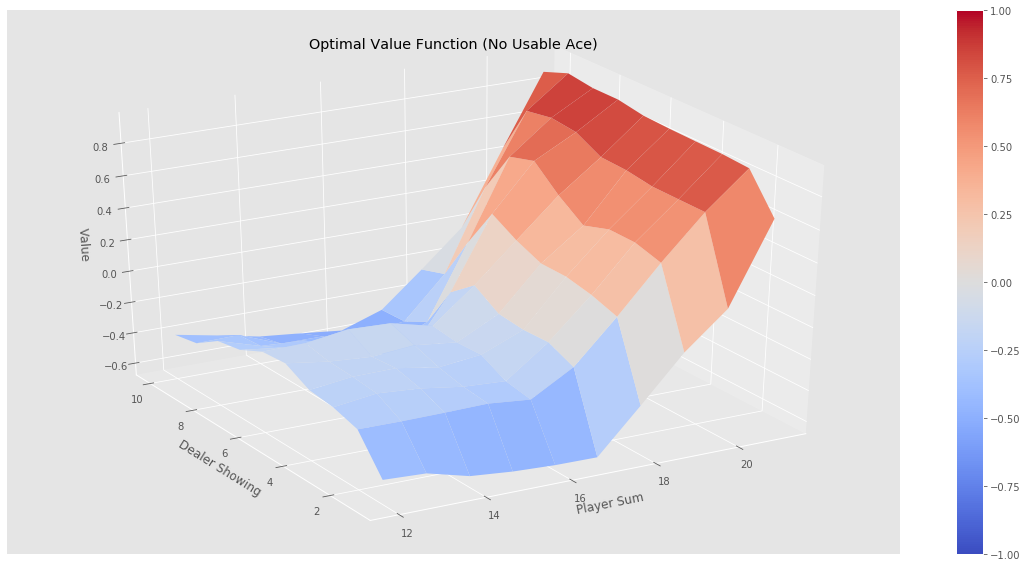

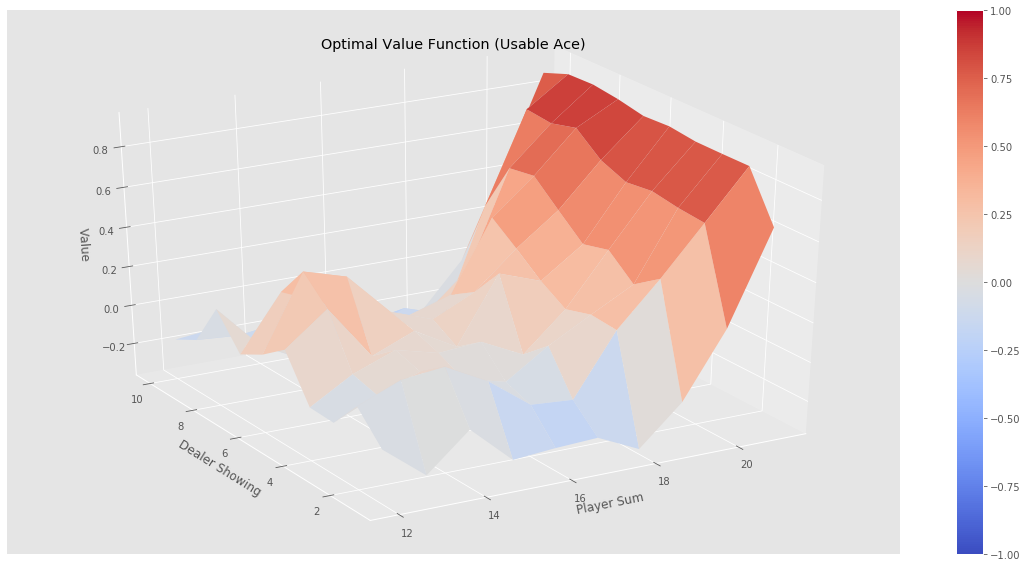

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")